In [562]:
import pandas as pd
import numpy as np
df = pd.read_csv('hotel_bookings.csv')
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [563]:
#combining date columns into a single pandas date time format 
df['date'] =pd.to_datetime(df.arrival_date_year.astype(str) + df.arrival_date_month.astype(str) + df.arrival_date_day_of_month.astype(str), format='%Y%B%d')
df['date'].dtype #data frame now contains a pandas date time format date column

dtype('<M8[ns]')

In [564]:
df = df.drop(['hotel', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'], axis=1)

In [565]:
#Let's only explore datapoints in 2017 population
#we only want dates past start of 2017
df = df.loc[(df['date'] >= '2017-01-01')& (df['date'] <= '2017-12-31')]


In [566]:
#extract a random sample of 600 for a two sample z test for comapring means
df = df.sample(n=1000)

Canceled bookings skewness: 1.0567945507277423


<AxesSubplot:>

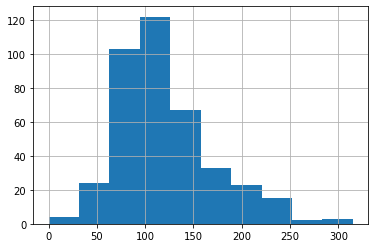

In [567]:
#check for outliers/skewness in our dataset for canceled bookings
print('Canceled bookings skewness:', df[df.is_canceled==1].adr.skew())
df[df.is_canceled==1].adr.hist()


Canceled bookings skewness: 0.982627091649876


<AxesSubplot:>

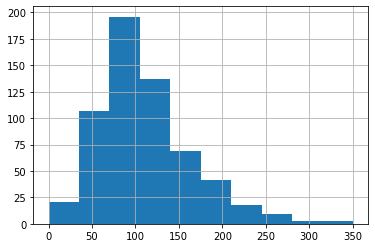

In [568]:
#check for outliers/skewness in our dataset for not canceled bookings
print('Canceled bookings skewness:', df[df.is_canceled==0].adr.skew())
df[df.is_canceled==0].adr.hist()

In [569]:
#Since skewness is higher than moderate let's remove any outliers using box plot calculations
#Canceled bookings outliers
df.sort_values("adr")
q1_canceled, q3_canceled= np.percentile(df[df.is_canceled==1].adr,[25,75])
print('Q1:', q1_canceled)
print('Q3:',q3_canceled)

Q1: 89.1
Q3: 140.0


In [570]:
iqr_canceled = q3_canceled - q1_canceled
iqr_canceled

50.900000000000006

In [571]:
lower_bound_canceled = q1_canceled -(1.5 * iqr_canceled)
upper_bound_canceled = q3_canceled +(1.5 * iqr_canceled)

print('Lower Bound_canceled:', lower_bound_canceled)
print('Upper Bound_canceled:', upper_bound_canceled)


Lower Bound_canceled: 12.749999999999986
Upper Bound_canceled: 216.35000000000002


In [572]:
##Since skewness is higher than moderate let's remove any outliers using box plot calculations
#Not Canceled bookings outliers
q1_not_canceled, q3_not_canceled= np.percentile(df[df.is_canceled==0].adr,[25,75])
print('Q1:', q1_not_canceled)
print('Q3:',q3_not_canceled)

iqr_not_canceled = q3_not_canceled - q1_not_canceled

lower_bound_not_canceled = q1_not_canceled -(1.5 * iqr_not_canceled)
upper_bound_not_canceled = q3_not_canceled +(1.5 * iqr_not_canceled)

print('Lower Bound_not_canceled:', lower_bound_not_canceled)
print('Upper Bound_not_canceled:', upper_bound_not_canceled)



Q1: 75.0
Q3: 139.05
Lower Bound_not_canceled: -21.075000000000017
Upper Bound_not_canceled: 235.12500000000003


In [573]:
#canceled_filter = df[df.is_canceled==1]
#df['adr_cleaned']=canceled_filter.adr[df.adr <0]
df1 = df[(df.is_canceled==1) & (df.adr>lower_bound_canceled) & (df.adr<upper_bound_canceled)]
df2 = df[(df.is_canceled==0) & (df.adr>lower_bound_not_canceled) & (df.adr<upper_bound_not_canceled)]

df = pd.concat([df1, df2], ignore_index=True)
df



,is_canceled,adr,date
0,1,85.00,2017-03-21
1,1,99.00,2017-05-05
2,1,130.00,2017-05-01
3,1,48.00,2017-05-10
4,1,90.00,2017-07-28
...,...,...,...
952,0,80.10,2017-07-12
953,0,110.20,2017-07-04
954,0,116.00,2017-04-22
955,0,123.88,2017-08-30


In [574]:
#Now we can see that skewness is below 0.5
print('Canceled bookings skewness:', df[df.is_canceled==1].adr.skew())
print('Not_Canceled bookings skewness:', df[df.is_canceled==0].adr.skew())

Canceled bookings skewness: 0.5453434799366844
Not_Canceled bookings skewness: 0.37902386591697124


In [575]:
#Below we will perform a ztest to compare means

In [576]:
import statsmodels.stats.weightstats as ws
not_canceled_adr = ws.DescrStatsW(df[df.is_canceled==0].adr)
canceled_adr = ws.DescrStatsW(df[df.is_canceled==1].adr)



In [577]:

cm_obj = ws.CompareMeans(canceled_adr, not_canceled_adr)
zstat, z_pval = cm_obj.ztest_ind()
print(zstat.round(4), z_pval)

2.3709 0.01774298839110564


In [ ]:
#We can conclude that means for the average daily rate for canceled and not canceled bookings are signficantly different 
#Average daily rate is a factor for whether a booking may be canceled or not